# Financial Complaint Classification using PyTorch Transformers

## Project Overview
This notebook performs multi-class text classification on consumer financial complaints into 4 categories:
- **0**: Credit reporting, repair, or other
- **1**: Debt collection
- **2**: Consumer Loan
- **3**: Mortgage

**Dataset**: 6GB Consumer Financial Protection Bureau (CFPB) complaints

**Hardware**: NVIDIA RTX 3060 Laptop GPU (6GB VRAM) with CUDA 12.1

**Approach**: Fine-tuned DistilBERT model optimized for memory efficiency

---

## 1. Environment Setup and Library Imports

Installing and importing all necessary libraries with GPU optimization settings.

In [1]:
# Install required packages (run once)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn
# !pip install accelerate -U

import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import gc
import os
import re
from html import unescape
import pickle
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# Transformers - CORRECTED IMPORT
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Import AdamW from PyTorch instead of transformers
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [2]:
# GPU Configuration and Memory Optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    
    # Memory optimization settings for 6GB VRAM
    torch.cuda.empty_cache()
    gc.collect()
    
    # Enable TF32 for faster training on Ampere GPUs (RTX 3060)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Enable cudnn benchmark for faster training
    torch.backends.cudnn.benchmark = True
    
    print("✓ GPU optimizations enabled")
else:
    print("⚠ GPU not available, using CPU")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

✓ GPU Available: NVIDIA GeForce RTX 3060 Laptop GPU
✓ CUDA Version: 12.1
✓ Total GPU Memory: 6.00 GB
✓ GPU optimizations enabled


---
## 2. Data Loading and Initial Exploration

Loading the 6GB dataset with optimized memory settings.

In [3]:
# Dataset path
DATA_PATH = r'C:\_Main\complaint_classification\complaints.csv'

# Load data with optimized dtypes
print("Loading dataset...")

dtype_dict = {
    'Date received': str,
    'Product': str,
    'Sub-product': str,
    'Issue': str,
    'Sub-issue': str,
    'Consumer complaint narrative': str,
    'Company': str,
    'State': str,
}

df = pd.read_csv(
    DATA_PATH,
    dtype=dtype_dict,
    low_memory=True
)

print(f"\n✓ Dataset loaded successfully")
print(f"✓ Total records: {len(df):,}")
print(f"✓ Total columns: {len(df.columns)}")
print(f"\nDataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

Loading dataset...

✓ Dataset loaded successfully
✓ Total records: 11,522,175
✓ Total columns: 18

Dataset shape: (11522175, 18)
Memory usage: 15.88 GB


In [4]:
# Display first few rows
print("First 5 rows of the dataset:")
print("="*100)
df.head()

First 5 rows of the dataset:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-10-15,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75287,NaN,NaN,Web,2025-10-15,In progress,Yes,NaN,16593757
4,2025-10-16,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,NC,28379,NaN,NaN,Web,2025-10-16,In progress,Yes,NaN,16623506


In [5]:
# Dataset info
print("Dataset Information:")
print("="*100)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11522175 entries, 0 to 11522174
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object

Missing Values Analysis:


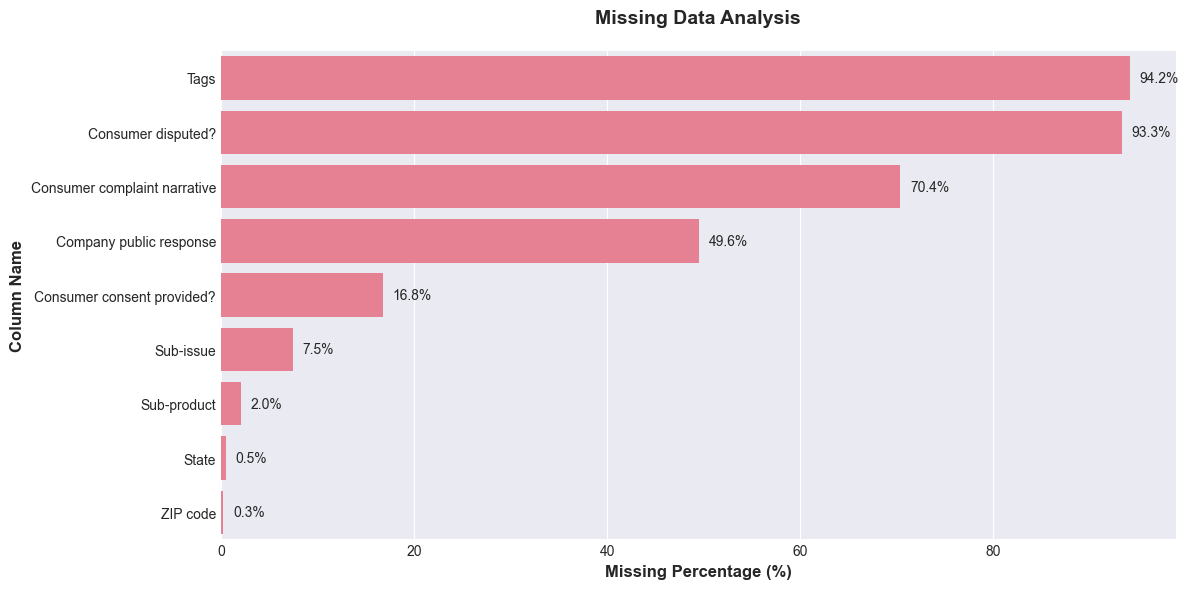

,Column,Missing_Count,Missing_Percentage
Tags,Tags,10850279,94.17
Consumer disputed?,Consumer disputed?,10753891,93.33
Consumer complaint narrative,Consumer complaint narrative,8107664,70.37
Company public response,Company public response,5711355,49.57
Consumer consent provided?,Consumer consent provided?,1936136,16.80
Sub-issue,Sub-issue,861936,7.48
Sub-product,Sub-product,235295,2.04
State,State,56852,0.49
ZIP code,ZIP code,30229,0.26
Date received,Date received,0,0.00


In [6]:
# Missing values analysis
print("Missing Values Analysis:")
print("="*100)
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

# Visualize missing data
fig, ax = plt.subplots(figsize=(12, 6))
missing_data_viz = missing_data[missing_data['Missing_Percentage'] > 0]

if len(missing_data_viz) > 0:
    sns.barplot(data=missing_data_viz, x='Missing_Percentage', y='Column', ax=ax)
    ax.set_xlabel('Missing Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Column Name', fontsize=12, fontweight='bold')
    ax.set_title('Missing Data Analysis', fontsize=14, fontweight='bold', pad=20)
    
    for i, v in enumerate(missing_data_viz['Missing_Percentage'].values):
        ax.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

missing_data

---
## 3. Exploratory Data Analysis and Feature Engineering

Understanding data distribution and creating target labels.

### 3.1 Product Category Analysis

In [7]:
# Product distribution
print("Product Distribution:")
print("="*100)
product_counts = df['Product'].value_counts()
print(product_counts.head(20))

Product Distribution:
Product
Credit reporting or other personal consumer reports                             6555928
Credit reporting, credit repair services, or other personal consumer reports    2163850
Debt collection                                                                  895870
Mortgage                                                                         430203
Checking or savings account                                                      315234
Credit card                                                                      258143
Credit card or prepaid card                                                      206368
Money transfer, virtual currency, or money service                               156115
Credit reporting                                                                 140429
Student loan                                                                     115045
Bank account or service                                                           86204
Ve

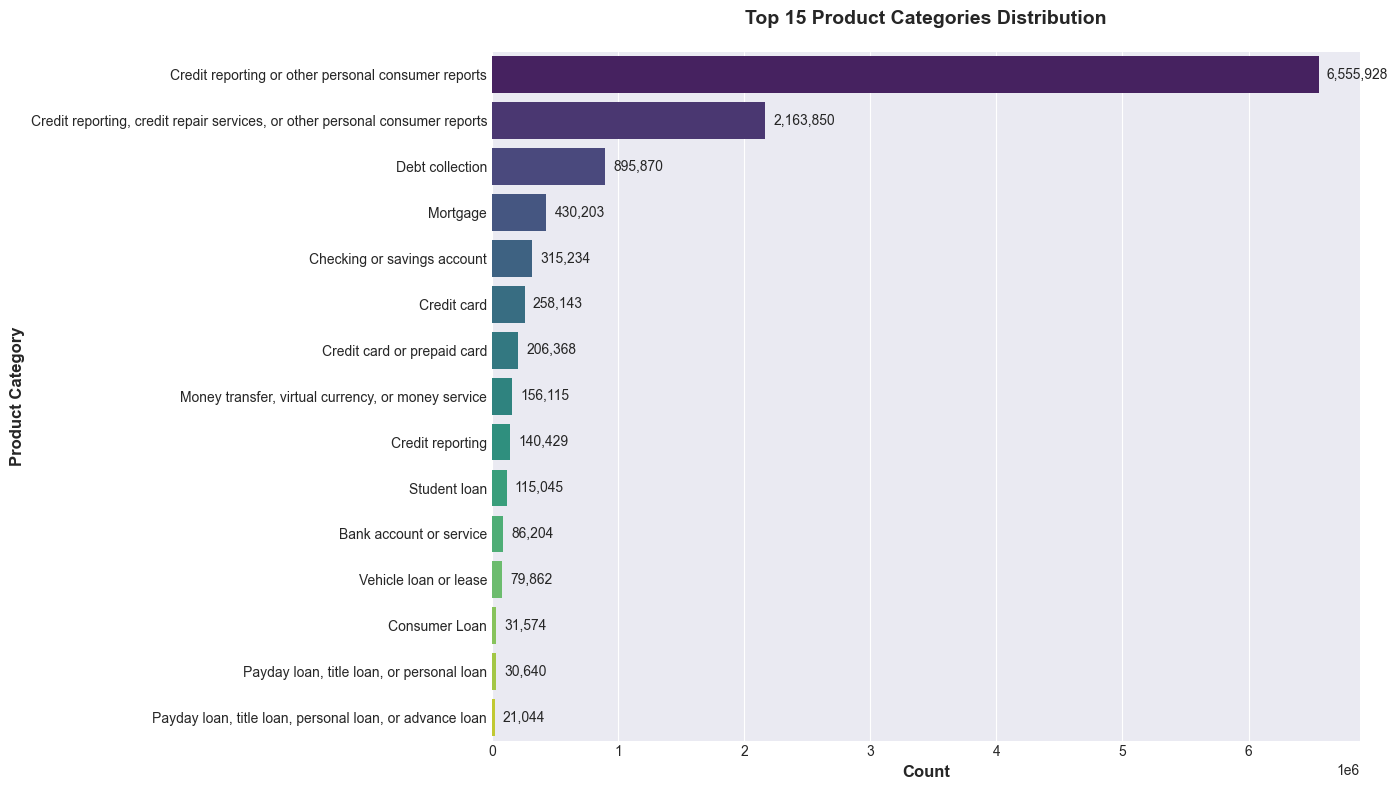


✓ Product distribution visualized


In [8]:
# Visualize product distribution
fig, ax = plt.subplots(figsize=(14, 8))

top_products = df['Product'].value_counts().head(15)
sns.barplot(x=top_products.values, y=top_products.index, ax=ax, palette='viridis')

ax.set_xlabel('Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Product Category', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Product Categories Distribution', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, v in enumerate(top_products.values):
    ax.text(v + max(top_products.values)*0.01, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Product distribution visualized")

### 3.2 Creating Target Labels

Mapping product categories to the 4 target classes:
- **0**: Credit reporting, repair, or other
- **1**: Debt collection
- **2**: Consumer Loan
- **3**: Mortgage

In [9]:
# Define mapping function
def map_to_category(product):
    """
    Maps product names to 4 categories:
    0: Credit reporting
    1: Debt collection
    2: Consumer Loan
    3: Mortgage
    """
    product_lower = str(product).lower()
    
    # Credit reporting
    if 'credit report' in product_lower or 'credit repair' in product_lower:
        return 0
    
    # Debt collection
    elif 'debt collection' in product_lower:
        return 1
    
    # Consumer Loan (includes personal, payday, student loans, vehicle loans)
    elif any(word in product_lower for word in ['consumer loan', 'personal loan', 'student loan', 
                                                   'payday loan', 'vehicle loan', 'installment loan']):
        return 2
    
    # Mortgage
    elif 'mortgage' in product_lower:
        return 3
    
    # Default to credit reporting for unclear cases
    else:
        return 0

# Apply mapping
df['target'] = df['Product'].apply(map_to_category)

# Define label names
label_names = {
    0: 'Credit Reporting',
    1: 'Debt Collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

print("Target Label Distribution:")
print("="*100)
target_dist = df['target'].value_counts().sort_index()
for label, count in target_dist.items():
    print(f"{label}: {label_names[label]:20s} - {count:,} ({count/len(df)*100:.2f}%)")

print(f"\n✓ Target labels created successfully")

Target Label Distribution:
0: Credit Reporting     - 9,912,396 (86.03%)
1: Debt Collection      - 895,870 (7.78%)
2: Consumer Loan        - 283,706 (2.46%)
3: Mortgage             - 430,203 (3.73%)

✓ Target labels created successfully


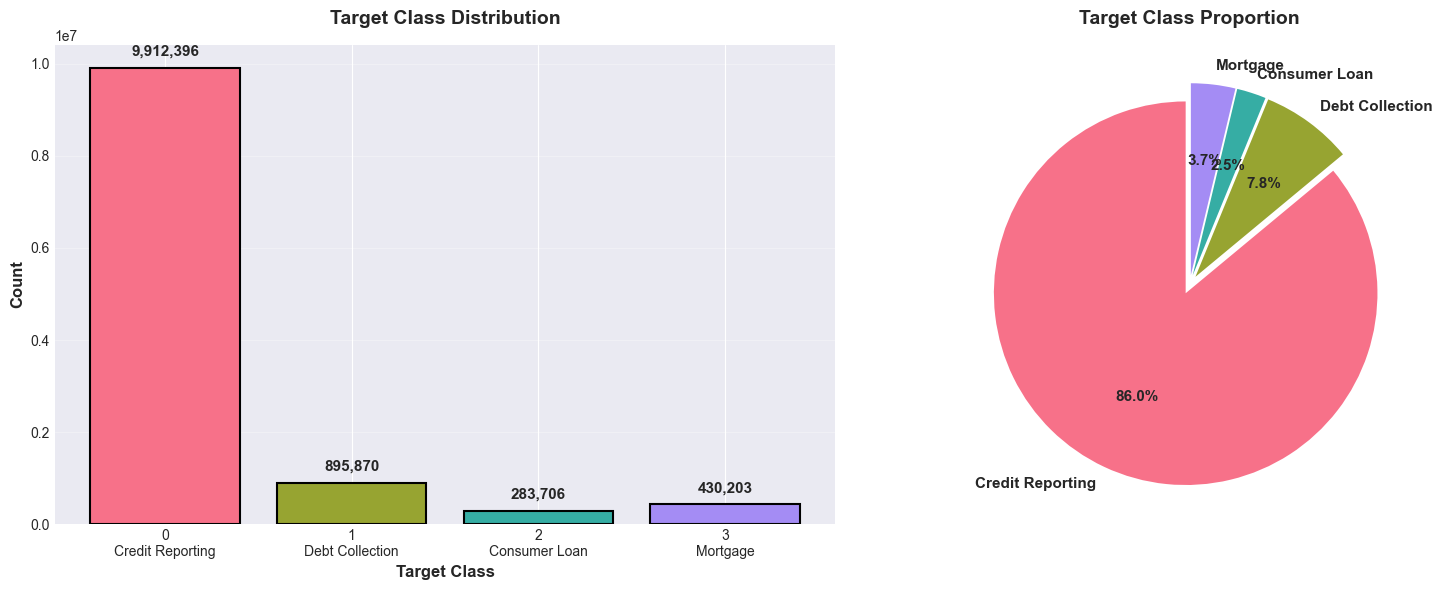


✓ Target distribution visualized


In [10]:
# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
target_counts = df['target'].value_counts().sort_index()
colors = sns.color_palette('husl', 4)
ax1.bar(range(4), target_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Target Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Target Class Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(range(4))
ax1.set_xticklabels([f"{i}\n{label_names[i]}" for i in range(4)], fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(target_counts.values):
    ax1.text(i, v + max(target_counts.values)*0.02, f'{v:,}', ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

# Pie chart
ax2.pie(target_counts.values, labels=[label_names[i] for i in range(4)], 
        autopct='%1.1f%%', startangle=90, colors=colors, 
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        explode=(0.05, 0.05, 0.05, 0.05))
ax2.set_title('Target Class Proportion', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n✓ Target distribution visualized")

### 3.3 Text Feature Engineering

In [11]:
# Combine relevant text fields for classification
def create_text_feature(row):
    """
    Combines multiple text fields into a single feature.
    Priority: Consumer complaint narrative > Issue + Sub-issue > Product
    """
    narrative = str(row.get('Consumer complaint narrative', ''))
    
    # If narrative exists and is substantial, use it
    if pd.notna(narrative) and narrative != 'nan' and len(narrative.strip()) > 50:
        return narrative.strip()
    
    # Otherwise, combine other fields
    parts = []
    
    if pd.notna(row.get('Issue')):
        parts.append(str(row['Issue']))
    
    if pd.notna(row.get('Sub-issue')):
        parts.append(str(row['Sub-issue']))
    
    if pd.notna(row.get('Product')):
        parts.append(str(row['Product']))
    
    if pd.notna(row.get('Sub-product')):
        parts.append(str(row['Sub-product']))
    
    return ' '.join(parts) if parts else 'No complaint text available'

print("Creating combined text feature...")
df['text'] = df.apply(create_text_feature, axis=1)

# Calculate text length
df['text_length'] = df['text'].str.len()

# Remove rows with missing or very short text
df = df[df['text_length'] > 10].copy()

print(f"\n✓ Text feature created")
print(f"✓ Records after filtering: {len(df):,}")

Creating combined text feature...

✓ Text feature created
✓ Records after filtering: 11,522,175


In [12]:
# Text length statistics
print("Text Length Statistics:")
print("="*100)
print(df['text_length'].describe())

# Text length by category
print("\nText Length by Category:")
print("="*100)
for target in range(4):
    stats = df[df['target'] == target]['text_length'].describe()
    print(f"\n{label_names[target]} (Class {target}):")
    print(stats)

Text Length Statistics:
count    1.152218e+07
mean     3.986271e+02
std      8.050089e+02
min      1.700000e+01
25%      1.410000e+02
50%      1.530000e+02
75%      2.530000e+02
max      3.598400e+04
Name: text_length, dtype: float64

Text Length by Category:

Credit Reporting (Class 0):
count    9.912396e+06
mean     3.793630e+02
std      7.595119e+02
min      1.700000e+01
25%      1.410000e+02
50%      1.550000e+02
75%      2.300000e+02
max      3.598400e+04
Name: text_length, dtype: float64

Debt Collection (Class 1):
count    895870.000000
mean        445.521653
std         891.108340
min          51.000000
25%          95.000000
50%         122.000000
75%         446.000000
max       32616.000000
Name: text_length, dtype: float64

Consumer Loan (Class 2):
count    283706.000000
mean        664.598792
std        1115.150623
min          32.000000
25%          98.000000
50%         135.000000
75%         874.000000
max       32959.000000
Name: text_length, dtype: float64

Mortgage (

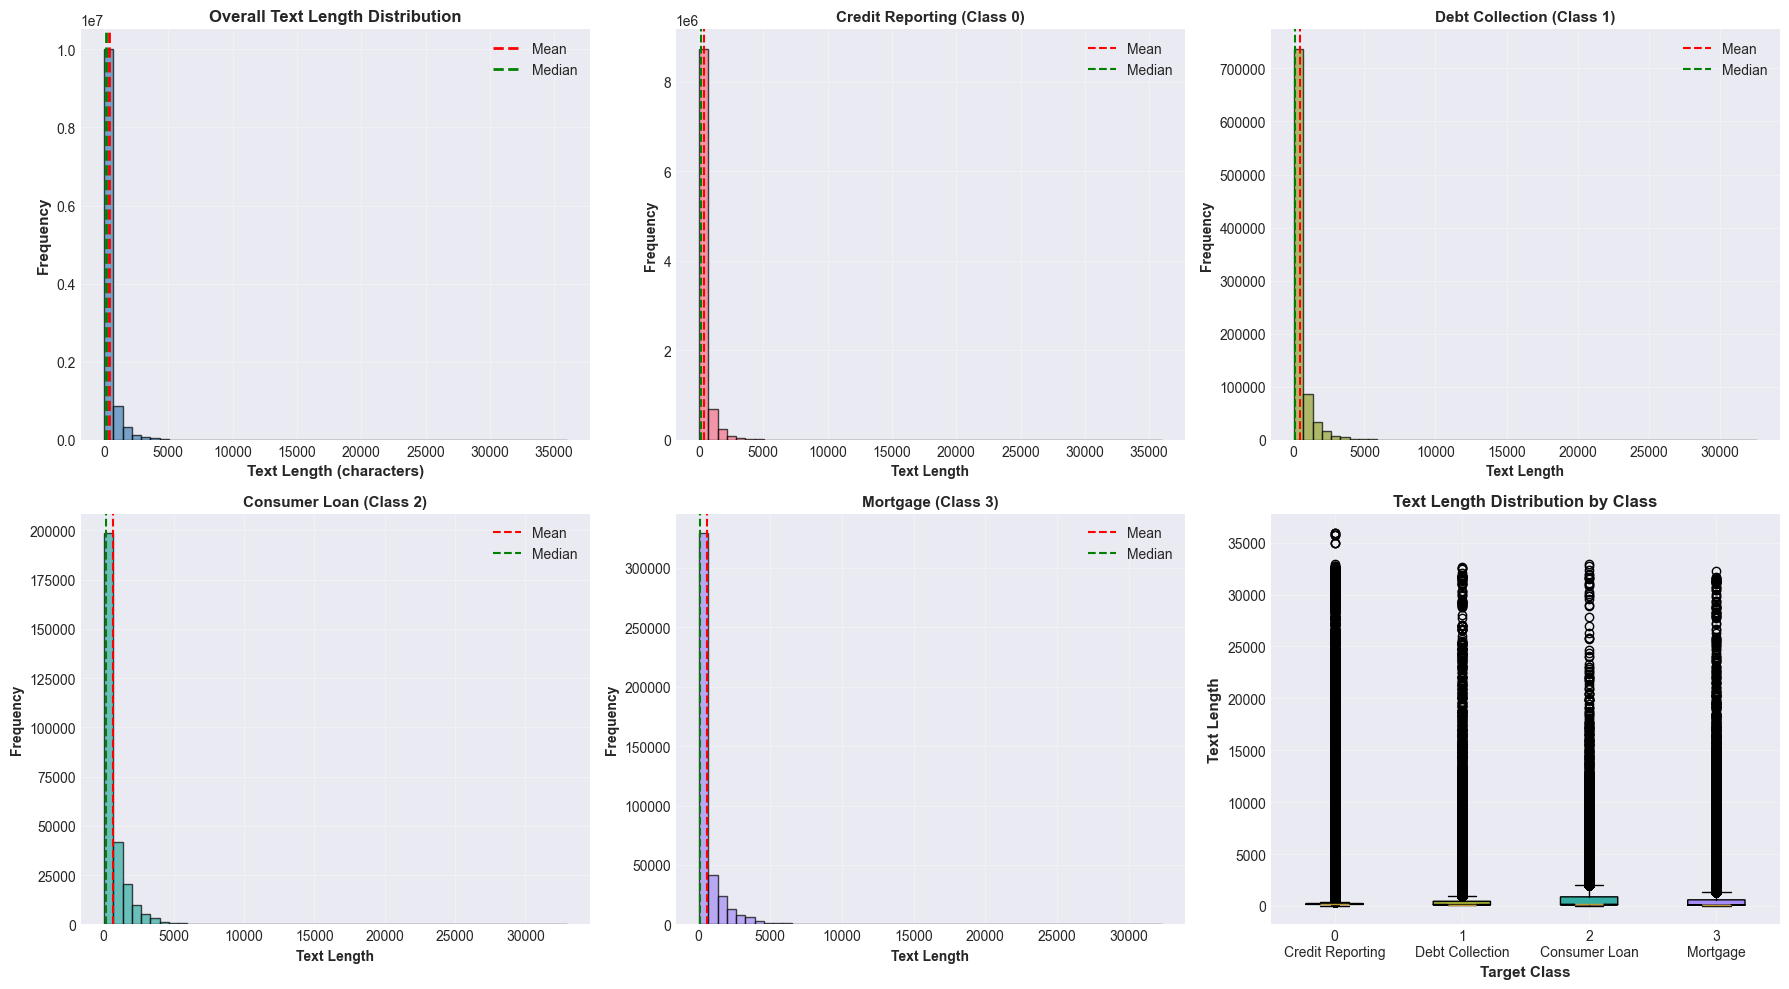


✓ Text length analysis completed


In [13]:
# Visualize text length distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Overall distribution
axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Text Length (characters)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Overall Text Length Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df['text_length'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By target class
for i, target in enumerate([0, 1, 2, 3]):
    ax = axes[i+1]
    data = df[df['target'] == target]['text_length']
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color=colors[i])
    ax.set_xlabel('Text Length', fontsize=10, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax.set_title(f'{label_names[target]} (Class {target})', fontsize=11, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=1.5, label='Mean')
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=1.5, label='Median')
    ax.legend()
    ax.grid(alpha=0.3)

# Box plot comparison
ax = axes[5]
data_by_target = [df[df['target'] == t]['text_length'] for t in range(4)]
bp = ax.boxplot(data_by_target, labels=[f"{i}\n{label_names[i]}" for i in range(4)], 
                patch_artist=True, notch=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylabel('Text Length', fontsize=11, fontweight='bold')
ax.set_xlabel('Target Class', fontsize=11, fontweight='bold')
ax.set_title('Text Length Distribution by Class', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Text length analysis completed")

In [14]:
# Sample texts from each category
print("Sample Texts from Each Category:")
print("="*100)

for target in range(4):
    print(f"\n{'='*100}")
    print(f"Class {target}: {label_names[target]}")
    print('='*100)
    
    sample_df = df[df['target'] == target]
    sample = sample_df['text'].sample(min(3, len(sample_df))).values
    
    for i, text in enumerate(sample, 1):
        print(f"\nExample {i}:")
        print(text[:400] + '...' if len(text) > 400 else text)

print("\n" + "="*100)

Sample Texts from Each Category:

Class 0: Credit Reporting

Example 1:
Problem with a company's investigation into an existing problem Their investigation did not fix an error on your report Credit reporting or other personal consumer reports Credit reporting

Example 2:
Incorrect information on your report Account status incorrect Credit reporting or other personal consumer reports Credit reporting

Example 3:
Improper use of your report Reporting company used your report improperly Credit reporting or other personal consumer reports Credit reporting

Class 1: Debt Collection

Example 1:
Written notification about debt Didn't receive enough information to verify debt Debt collection Auto debt

Example 2:
This debt with portfolio recovery associates is well past the 8 year collection mark. It is no longer in collections or listed in credit reports. I recently paid off another card account, since that time whej they received my cantact info they have started calling day and night multi

---
## 4. Text Preprocessing

Cleaning and preparing text data for transformer models.

In [15]:
def preprocess_text(text):
    """
    Clean and preprocess text for transformer models.
    """
    # Convert to string
    text = str(text)
    
    # Decode HTML entities
    text = unescape(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Replace XXXX patterns (anonymization)
    text = re.sub(r'X+', 'XXXX', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    # Keep only if text is substantial
    if len(text) < 10:
        return None
    
    return text

print("Preprocessing text...")
tqdm.pandas(desc="Processing texts")
df['text_clean'] = df['text'].progress_apply(preprocess_text)

# Remove None values
initial_len = len(df)
df = df[df['text_clean'].notna()].copy()

print(f"\n✓ Text preprocessing completed")
print(f"✓ Records removed: {initial_len - len(df):,}")
print(f"✓ Final dataset size: {len(df):,} records")

Preprocessing text...


Processing texts:   0%|          | 0/11522175 [00:00<?, ?it/s]


✓ Text preprocessing completed
✓ Records removed: 1
✓ Final dataset size: 11,522,174 records


In [16]:
# Before and after preprocessing examples
print("Text Preprocessing Examples:")
print("="*100)

for i in range(min(3, len(df))):
    print(f"\nExample {i+1}:")
    print(f"Original: {df.iloc[i]['text'][:200]}...")
    print(f"Cleaned:  {df.iloc[i]['text_clean'][:200]}...")
    print("-"*100)

Text Preprocessing Examples:

Example 1:
Original: Incorrect information on your report Information belongs to someone else Credit reporting, credit repair services, or other personal consumer reports Credit reporting...
Cleaned:  Incorrect information on your report Information belongs to someone else Credit reporting, credit repair services, or other personal consumer reports Credit reporting...
----------------------------------------------------------------------------------------------------

Example 2:
Original: Incorrect information on your report Information is missing that should be on the report Credit reporting or other personal consumer reports Credit reporting...
Cleaned:  Incorrect information on your report Information is missing that should be on the report Credit reporting or other personal consumer reports Credit reporting...
----------------------------------------------------------------------------------------------------

Example 3:
Original: Incorrect information

### 4.1 Data Split Strategy

In [17]:
# Due to the large dataset size (6GB), we'll use a stratified sample for training
# This ensures we can train efficiently on the 6GB GPU without OOM errors

# Sample size calculation (adjust based on available memory)
SAMPLE_SIZE = 200000  # Using 200K samples for efficient training

if len(df) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE:,} records from {len(df):,} total records...")
    df_sample = df.groupby('target', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 4), random_state=SEED)
    ).reset_index(drop=True)
else:
    df_sample = df.copy()

print(f"\nWorking dataset size: {len(df_sample):,}")
print("\nClass distribution in sample:")
for target in range(4):
    count = (df_sample['target'] == target).sum()
    print(f"Class {target} ({label_names[target]}): {count:,} ({count/len(df_sample)*100:.2f}%)")

Sampling 200,000 records from 11,522,174 total records...

Working dataset size: 200,000

Class distribution in sample:
Class 0 (Credit Reporting): 50,000 (25.00%)
Class 1 (Debt Collection): 50,000 (25.00%)
Class 2 (Consumer Loan): 50,000 (25.00%)
Class 3 (Mortgage): 50,000 (25.00%)


In [18]:
# Train-validation-test split
print("Splitting data into train, validation, and test sets...")

# First split: separate test set (15%)
X = df_sample['text_clean'].values
y = df_sample['target'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)

# Second split: separate validation set (15% of remaining = ~12.75% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=SEED, stratify=y_temp
)

print(f"\n✓ Data split completed")
print(f"✓ Training set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Validation set: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"✓ Test set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print("\nClass distribution:")
print("="*100)
for split_name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    print(f"\n{split_name}:")
    for target in range(4):
        count = (y_split == target).sum()
        print(f"  Class {target}: {count:,} ({count/len(y_split)*100:.2f}%)")

Splitting data into train, validation, and test sets...

✓ Data split completed
✓ Training set: 144,500 (72.2%)
✓ Validation set: 25,500 (12.8%)
✓ Test set: 30,000 (15.0%)

Class distribution:

Train:
  Class 0: 36,125 (25.00%)
  Class 1: 36,125 (25.00%)
  Class 2: 36,125 (25.00%)
  Class 3: 36,125 (25.00%)

Validation:
  Class 0: 6,375 (25.00%)
  Class 1: 6,375 (25.00%)
  Class 2: 6,375 (25.00%)
  Class 3: 6,375 (25.00%)

Test:
  Class 0: 7,500 (25.00%)
  Class 1: 7,500 (25.00%)
  Class 2: 7,500 (25.00%)
  Class 3: 7,500 (25.00%)


---
## 5. Model Selection and Preparation

Using DistilBERT for efficient training on 6GB GPU.

In [19]:
# Model configuration
MODEL_NAME = 'distilbert-base-uncased'  # Lighter than BERT, perfect for 6GB VRAM
MAX_LENGTH = 128  # Reduced from 512 to save memory
BATCH_SIZE = 16  # Optimized for 6GB GPU
GRADIENT_ACCUMULATION_STEPS = 2  # Effective batch size = 32
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500
NUM_LABELS = 4

print("Model Configuration:")
print("="*100)
print(f"Model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Gradient accumulation steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of labels: {NUM_LABELS}")

Model Configuration:
Model: distilbert-base-uncased
Max sequence length: 128
Batch size: 16
Gradient accumulation steps: 2
Effective batch size: 32
Number of epochs: 3
Learning rate: 2e-05
Number of labels: 4


In [20]:
# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded successfully")

Loading tokenizer...
✓ Tokenizer loaded successfully


### 5.1 Custom Dataset Class

In [21]:
class ComplaintDataset(Dataset):
    """
    Custom PyTorch Dataset for financial complaints.
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ ComplaintDataset class defined")

✓ ComplaintDataset class defined


In [22]:
# Create datasets
print("Creating datasets...")

train_dataset = ComplaintDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ComplaintDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = ComplaintDataset(X_test, y_test, tokenizer, MAX_LENGTH)

print(f"\n✓ Datasets created")
print(f"✓ Training samples: {len(train_dataset):,}")
print(f"✓ Validation samples: {len(val_dataset):,}")
print(f"✓ Test samples: {len(test_dataset):,}")

Creating datasets...

✓ Datasets created
✓ Training samples: 144,500
✓ Validation samples: 25,500
✓ Test samples: 30,000


In [23]:
# Create dataloaders with Windows-compatible settings
print("Creating dataloaders...")

# IMPORTANT: On Windows with Jupyter, num_workers MUST be 0
# This is a known PyTorch issue on Windows
NUM_WORKERS = 0  # Must be 0 on Windows/Jupyter

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,  # Changed to 0 for Windows
    pin_memory=False  # Also set to False to avoid issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=NUM_WORKERS,  # Changed to 0 for Windows
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=NUM_WORKERS,  # Changed to 0 for Windows
    pin_memory=False
)

print(f"\n✓ Dataloaders created")
print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")
print(f"\n⚠ Note: Using num_workers=0 for Windows compatibility")


Creating dataloaders...

✓ Dataloaders created
✓ Training batches: 9032
✓ Validation batches: 797
✓ Test batches: 938

⚠ Note: Using num_workers=0 for Windows compatibility


### 5.2 Model Initialization

In [24]:
# Load pre-trained model
print("Loading pre-trained model...")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
)

# Move model to GPU
model = model.to(device)

print(f"\n✓ Model loaded and moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

# Check GPU memory
if torch.cuda.is_available():
    print(f"\nGPU Memory Status:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

Loading pre-trained model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded and moved to cuda
✓ Total parameters: 66,956,548
✓ Trainable parameters: 66,956,548

GPU Memory Status:
  Allocated: 0.25 GB
  Cached: 0.29 GB


### 5.3 Training Setup

In [25]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
total_steps = len(train_loader) * NUM_EPOCHS // GRADIENT_ACCUMULATION_STEPS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Mixed precision training for memory efficiency
scaler = GradScaler()

print("Training Setup:")
print("="*100)
print(f"✓ Optimizer: AdamW")
print(f"✓ Learning rate: {LEARNING_RATE}")
print(f"✓ Total training steps: {total_steps:,}")
print(f"✓ Warmup steps: {WARMUP_STEPS}")
print(f"✓ Mixed precision training: Enabled")
print(f"✓ Gradient accumulation steps: {GRADIENT_ACCUMULATION_STEPS}")

Training Setup:
✓ Optimizer: AdamW
✓ Learning rate: 2e-05
✓ Total training steps: 13,548
✓ Warmup steps: 500
✓ Mixed precision training: Enabled
✓ Gradient accumulation steps: 2


---
## 6. Model Training

Training with memory optimization for RTX 3060 6GB GPU.

In [26]:
# Training and evaluation functions - Windows optimized
def train_epoch(model, dataloader, optimizer, scheduler, scaler, device, accumulation_steps):
    """
    Train for one epoch with gradient accumulation and mixed precision.
    """
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    optimizer.zero_grad()
    
    # Use simpler progress tracking for Windows
    print(f"Training: 0/{len(dataloader)} batches", end='\r')
    
    for step, batch in enumerate(dataloader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Mixed precision training
        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss / accumulation_steps
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        
        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # Update progress every 10 batches to avoid overhead
        if step % 10 == 0:
            print(f"Training: {step}/{len(dataloader)} batches | Loss: {loss.item() * accumulation_steps:.4f}", end='\r')
        
        # Memory cleanup
        del input_ids, attention_mask, labels, outputs, loss, preds
        if step % 100 == 0:
            torch.cuda.empty_cache()
    
    print()  # New line after progress
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy


def evaluate(model, dataloader, device):
    """
    Evaluate the model.
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    print(f"Evaluating: 0/{len(dataloader)} batches", end='\r')
    
    with torch.no_grad():
        for step, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
            
            total_loss += outputs.loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            # Update progress
            if step % 10 == 0:
                print(f"Evaluating: {step}/{len(dataloader)} batches", end='\r')
            
            # Memory cleanup
            del input_ids, attention_mask, labels, outputs, preds
    
    print()  # New line after progress
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

print("✓ Training functions defined (Windows-optimized)")


✓ Training functions defined (Windows-optimized)


In [27]:
# Training loop
print("Starting training...")
print("="*100)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*100}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print('='*100)
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, scaler, 
        device, GRADIENT_ACCUMULATION_STEPS
    )
    
    # Validation
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.4f})")
    
    # GPU memory status
    if torch.cuda.is_available():
        print(f"\n  GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB allocated")
    
    # Cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n{'='*100}")
print("✓ Training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print("✓ Best model loaded")

Starting training...

Epoch 1/3
Training: 9030/9032 batches | Loss: 0.2873
Evaluating: 790/797 batches

Epoch 1 Results:
  Train Loss: 0.2064 | Train Acc: 0.9310
  Val Loss:   0.1344 | Val Acc:   0.9552
  ✓ New best model saved! (Val Acc: 0.9552)

  GPU Memory: 0.78 GB allocated

Epoch 2/3
Training: 9030/9032 batches | Loss: 0.0193
Evaluating: 790/797 batches

Epoch 2 Results:
  Train Loss: 0.1153 | Train Acc: 0.9623
  Val Loss:   0.1351 | Val Acc:   0.9569
  ✓ New best model saved! (Val Acc: 0.9569)

  GPU Memory: 0.78 GB allocated

Epoch 3/3
Training: 9030/9032 batches | Loss: 0.0082
Evaluating: 790/797 batches

Epoch 3 Results:
  Train Loss: 0.0849 | Train Acc: 0.9732
  Val Loss:   0.1429 | Val Acc:   0.9573
  ✓ New best model saved! (Val Acc: 0.9573)

  GPU Memory: 0.78 GB allocated

✓ Training completed!
✓ Best validation accuracy: 0.9573
✓ Best model loaded


### 6.1 Training History Visualization

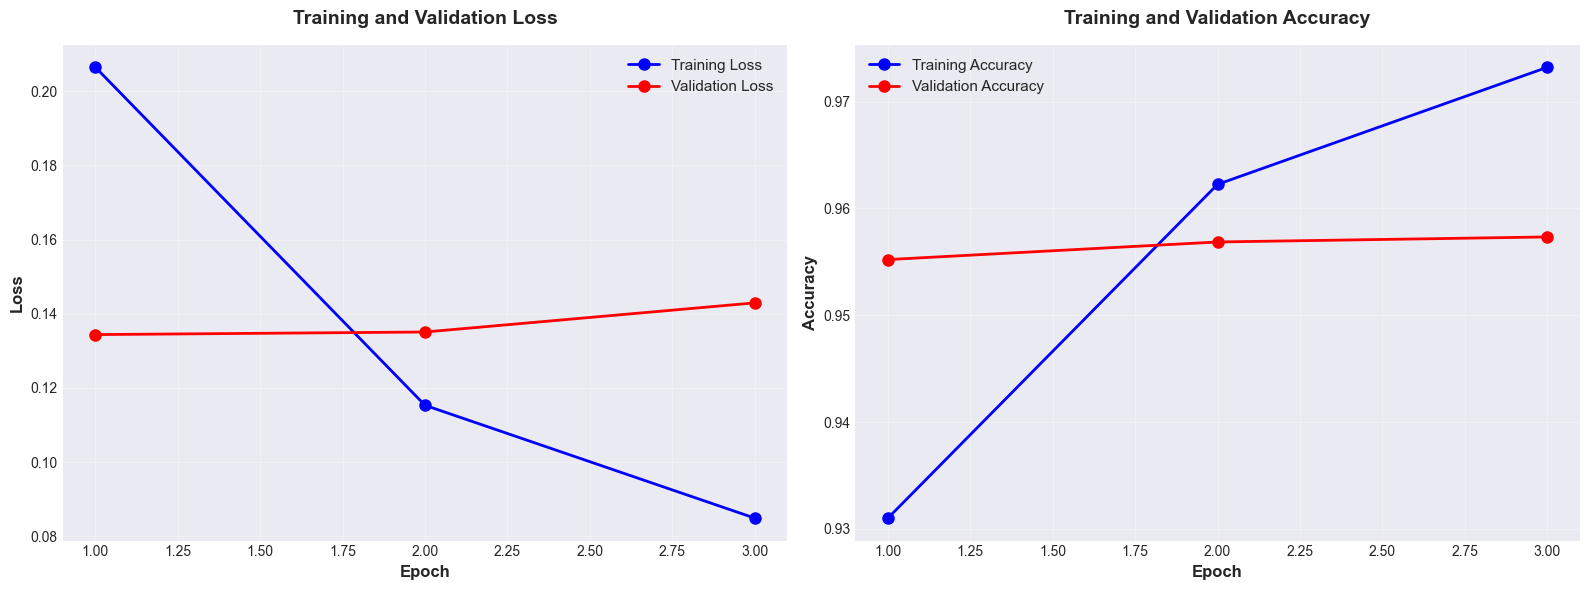

✓ Training history visualized


In [28]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2, markersize=8)
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
ax2.plot(epochs_range, history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history visualized")

---
## 7. Model Evaluation

Comprehensive evaluation on test set.

In [29]:
# Evaluate on test set
print("Evaluating on test set...")
print("="*100)

test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, device)

print(f"\nTest Set Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

Evaluating on test set...
Evaluating: 930/938 batches

Test Set Results:
  Test Loss: 0.1421
  Test Accuracy: 0.9585


### 7.1 Classification Report

In [30]:
# Detailed classification report
print("Classification Report:")
print("="*100)

target_names = [label_names[i] for i in range(NUM_LABELS)]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

# Get per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Create detailed metrics dataframe
metrics_df = pd.DataFrame({
    'Class': [f"{i} - {label_names[i]}" for i in range(NUM_LABELS)],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nDetailed Metrics:")
print(metrics_df.to_string(index=False))

Classification Report:
                  precision    recall  f1-score   support

Credit Reporting     0.9555    0.9559    0.9557      7500
 Debt Collection     0.9439    0.9425    0.9432      7500
   Consumer Loan     0.9516    0.9532    0.9524      7500
        Mortgage     0.9831    0.9824    0.9827      7500

        accuracy                         0.9585     30000
       macro avg     0.9585    0.9585    0.9585     30000
    weighted avg     0.9585    0.9585    0.9585     30000


Detailed Metrics:
               Class  Precision   Recall  F1-Score  Support
0 - Credit Reporting   0.955484 0.955867  0.955676     7500
 1 - Debt Collection   0.943918 0.942533  0.943225     7500
   2 - Consumer Loan   0.951551 0.953200  0.952375     7500
        3 - Mortgage   0.983055 0.982400  0.982728     7500


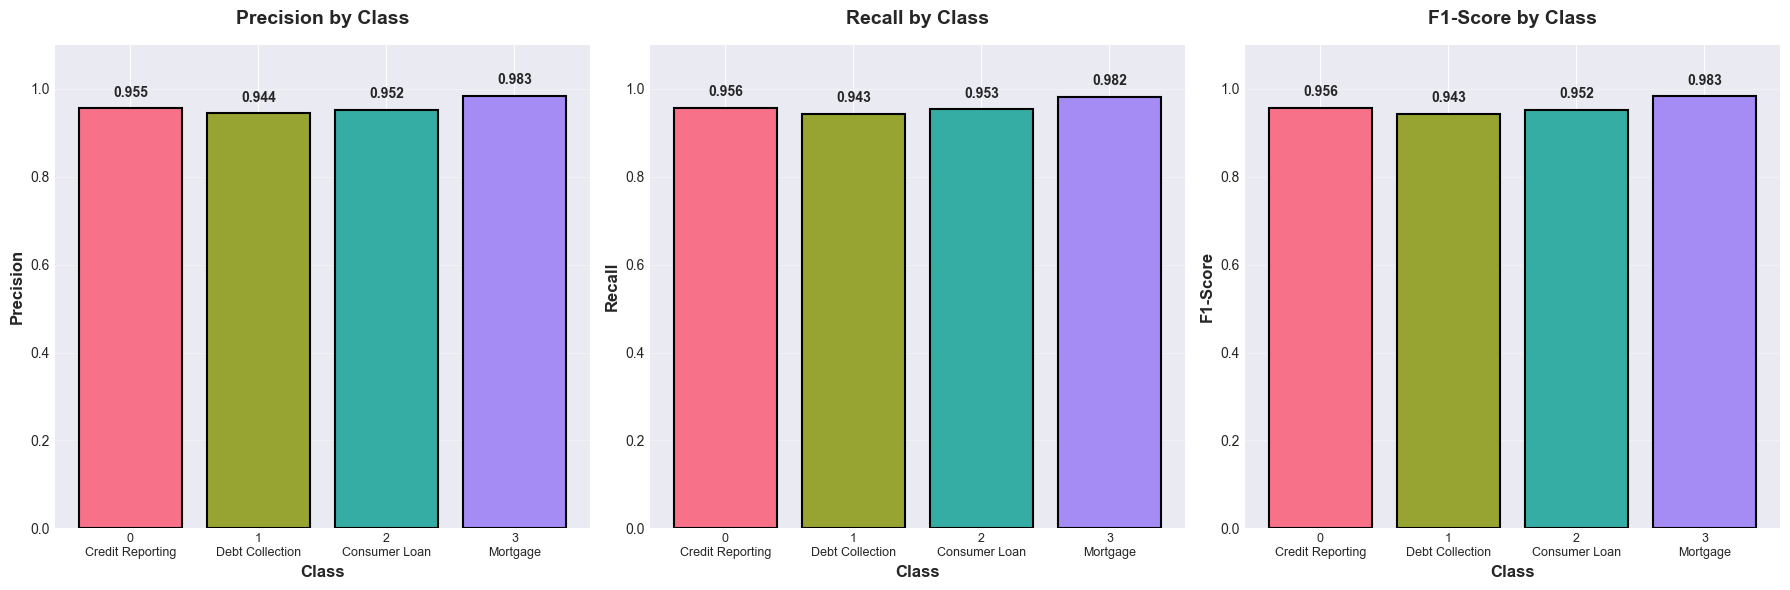

✓ Per-class metrics visualized


In [31]:
# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Precision', 'Recall', 'F1-Score']
colors_bar = sns.color_palette('husl', NUM_LABELS)

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    values = metrics_df[metric].values
    bars = ax.bar(range(NUM_LABELS), values, color=colors_bar, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} by Class', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(NUM_LABELS))
    ax.set_xticklabels([f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)], fontsize=9)
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Per-class metrics visualized")

### 7.2 Confusion Matrix

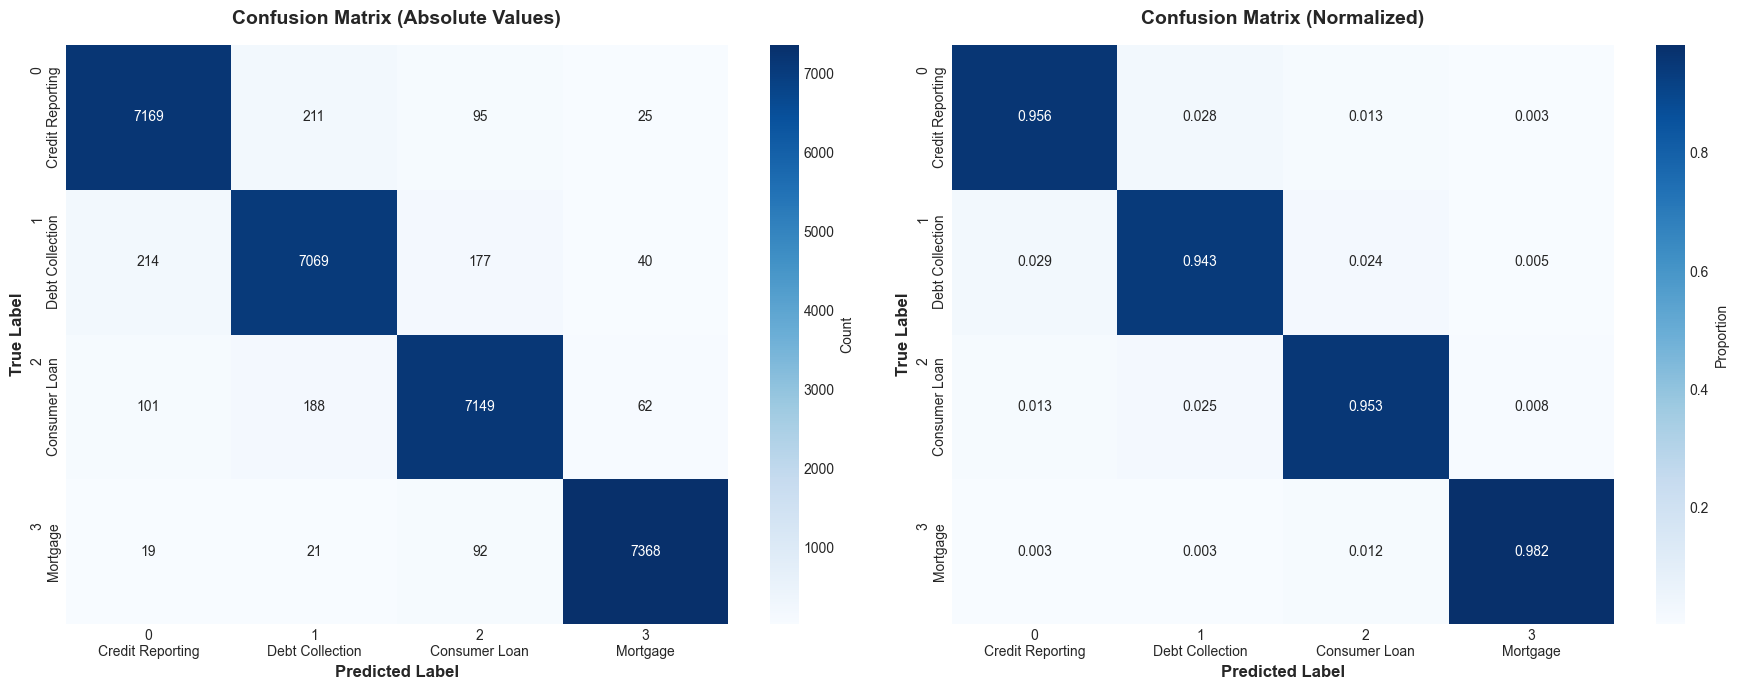

✓ Confusion matrix visualized


In [32]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Absolute values
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            yticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Absolute Values)', fontsize=14, fontweight='bold', pad=15)

# Normalized values
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', ax=ax2,
            xticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            yticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            cbar_kws={'label': 'Proportion'})
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("✓ Confusion matrix visualized")

### 7.3 Error Analysis

In [33]:
# Identify misclassified samples
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)
misclassified_idx = np.where(y_true_array != y_pred_array)[0]

print(f"Error Analysis:")
print("="*100)
print(f"Total predictions: {len(y_true):,}")
print(f"Correct predictions: {(y_true_array == y_pred_array).sum():,}")
print(f"Misclassified: {len(misclassified_idx):,} ({len(misclassified_idx)/len(y_true)*100:.2f}%)")

# Analyze errors by class
print("\nErrors by True Class:")
for true_class in range(NUM_LABELS):
    true_class_idx = np.where(y_true_array == true_class)[0]
    true_class_errors = np.intersect1d(true_class_idx, misclassified_idx)
    error_rate = len(true_class_errors) / len(true_class_idx) * 100 if len(true_class_idx) > 0 else 0
    print(f"  Class {true_class} ({label_names[true_class]}): {len(true_class_errors):,}/{len(true_class_idx):,} ({error_rate:.2f}%)")

Error Analysis:
Total predictions: 30,000
Correct predictions: 28,755
Misclassified: 1,245 (4.15%)

Errors by True Class:
  Class 0 (Credit Reporting): 331/7,500 (4.41%)
  Class 1 (Debt Collection): 431/7,500 (5.75%)
  Class 2 (Consumer Loan): 351/7,500 (4.68%)
  Class 3 (Mortgage): 132/7,500 (1.76%)


In [34]:
# Sample misclassified examples
print("\nSample Misclassified Examples:")
print("="*100)

num_samples = min(10, len(misclassified_idx))
sample_errors = np.random.choice(misclassified_idx, num_samples, replace=False)

for i, idx in enumerate(sample_errors, 1):
    true_label = y_true_array[idx]
    pred_label = y_pred_array[idx]
    text = X_test[idx]
    
    print(f"\nError Example {i}:")
    print(f"  True Label: {true_label} ({label_names[true_label]})")
    print(f"  Predicted Label: {pred_label} ({label_names[pred_label]})")
    print(f"  Text: {text[:300]}...")
    print("-"*100)


Sample Misclassified Examples:

Error Example 1:
  True Label: 1 (Debt Collection)
  Predicted Label: 0 (Credit Reporting)
  Text: Discover Card made claims that I was indebted to their company. I disagree with this claim. Discover Card misrepresented material facts that would have lead me to make other decisions based on our business relationship. My endorsements on the contract gives it value and Discover Card then sold the i...
----------------------------------------------------------------------------------------------------

Error Example 2:
  True Label: 1 (Debt Collection)
  Predicted Label: 2 (Consumer Loan)
  Text: Company is refusing to understand that my devices were compromised and that I did not purposefully take out this loan. The actions of depositing the funds into my account and me communicating with the lender happened as a result of identity theft including access to bank account information....
----------------------------------------------------------------------

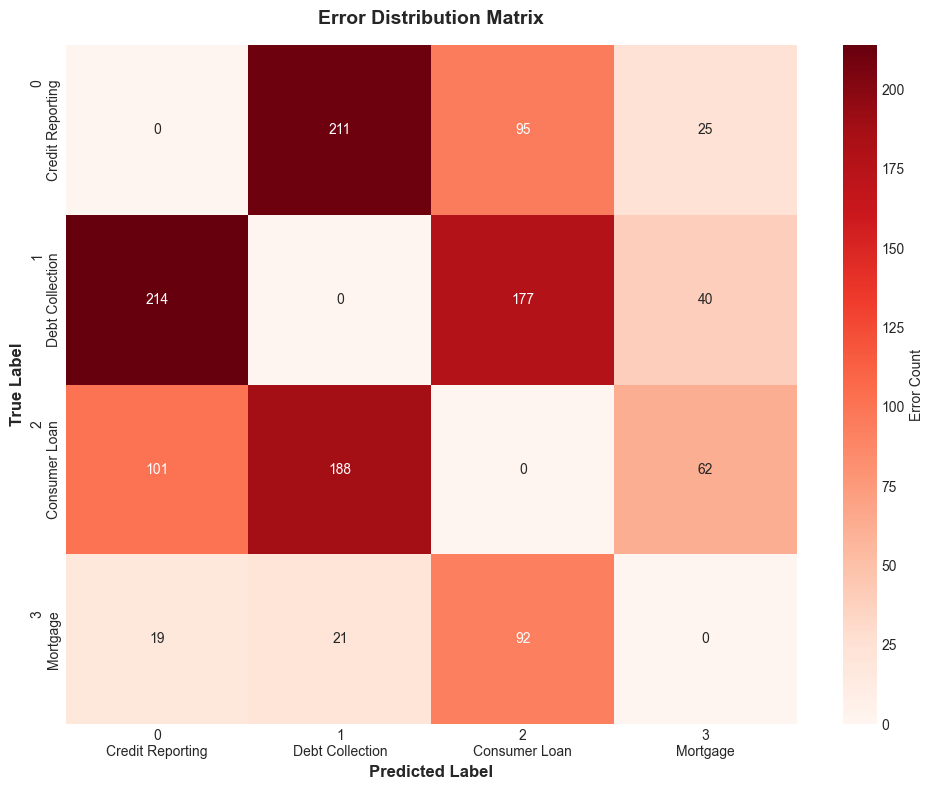

✓ Error analysis completed


In [35]:
# Error distribution heatmap
error_matrix = np.zeros((NUM_LABELS, NUM_LABELS), dtype=int)

for true_label, pred_label in zip(y_true_array[misclassified_idx], y_pred_array[misclassified_idx]):
    error_matrix[true_label][pred_label] += 1

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds', ax=ax,
            xticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            yticklabels=[f"{i}\n{label_names[i]}" for i in range(NUM_LABELS)],
            cbar_kws={'label': 'Error Count'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Error Distribution Matrix', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("✓ Error analysis completed")

---
## 8. Model Saving

Saving the trained model and tokenizer for future use.

In [36]:
# Create model directory
MODEL_SAVE_PATH = r'C:\_Main\complaint_classification\models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print("Saving model and tokenizer...")

# Save model
model.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Model saved to {MODEL_SAVE_PATH}")

# Save tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Tokenizer saved to {MODEL_SAVE_PATH}")

# Save label mapping
label_mapping = {
    'label_names': label_names,
    'num_labels': NUM_LABELS
}

with open(os.path.join(MODEL_SAVE_PATH, 'label_mapping.pkl'), 'wb') as f:
    pickle.dump(label_mapping, f)
print(f"✓ Label mapping saved")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(MODEL_SAVE_PATH, 'training_history.csv'), index=False)
print(f"✓ Training history saved")

# Save configuration
config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'best_val_acc': best_val_acc,
    'test_acc': test_acc
}

with open(os.path.join(MODEL_SAVE_PATH, 'config.pkl'), 'wb') as f:
    pickle.dump(config, f)
print(f"✓ Configuration saved")

print("\n" + "="*100)
print("✓ All files saved successfully!")

Saving model and tokenizer...
✓ Model saved to C:\_Main\complaint_classification\models
✓ Tokenizer saved to C:\_Main\complaint_classification\models
✓ Label mapping saved
✓ Training history saved
✓ Configuration saved

✓ All files saved successfully!


---
## 9. Prediction Function

Creating a function for making predictions on new complaints.

In [37]:
def predict_complaint(text, model, tokenizer, device, max_length=128):
    """
    Predict the category of a financial complaint.
    
    Args:
        text (str): The complaint text
        model: The trained model
        tokenizer: The tokenizer
        device: The device (cuda/cpu)
        max_length (int): Maximum sequence length
    
    Returns:
        dict: Prediction results with class probabilities
    """
    # Preprocess text
    text_clean = preprocess_text(text)
    
    # Tokenize
    encoding = tokenizer(
        text_clean,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    
    # Format results
    results = {
        'predicted_class': predicted_class,
        'predicted_label': label_names[predicted_class],
        'confidence': confidence,
        'all_probabilities': {label_names[i]: probabilities[0][i].item() for i in range(NUM_LABELS)}
    }
    
    return results

print("✓ Prediction function defined")

✓ Prediction function defined


### 9.1 Test Predictions on Sample Texts

In [38]:
# Sample test cases
test_cases = [
    "There are incorrect items on my credit report that I did not authorize. These accounts do not belong to me.",
    "I am being contacted by a debt collector for a debt I do not owe. They are calling me multiple times a day.",
    "I took out a personal loan and I am having issues with the repayment terms. The interest rate is too high.",
    "My mortgage payment has increased significantly and I was not properly notified. I need help understanding the changes."
]

print("Testing Prediction Function:")
print("="*100)

for i, text in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    print(f"Text: {text}")
    print("-"*100)
    
    results = predict_complaint(text, model, tokenizer, device, MAX_LENGTH)
    
    print(f"Predicted Class: {results['predicted_class']}")
    print(f"Predicted Label: {results['predicted_label']}")
    print(f"Confidence: {results['confidence']:.4f}")
    print(f"\nAll Probabilities:")
    for label, prob in results['all_probabilities'].items():
        print(f"  {label}: {prob:.4f}")
    print("="*100)

Testing Prediction Function:

Test Case 1:
Text: There are incorrect items on my credit report that I did not authorize. These accounts do not belong to me.
----------------------------------------------------------------------------------------------------
Predicted Class: 0
Predicted Label: Credit Reporting
Confidence: 0.9951

All Probabilities:
  Credit Reporting: 0.9951
  Debt Collection: 0.0031
  Consumer Loan: 0.0016
  Mortgage: 0.0001

Test Case 2:
Text: I am being contacted by a debt collector for a debt I do not owe. They are calling me multiple times a day.
----------------------------------------------------------------------------------------------------
Predicted Class: 1
Predicted Label: Debt Collection
Confidence: 0.9980

All Probabilities:
  Credit Reporting: 0.0006
  Debt Collection: 0.9980
  Consumer Loan: 0.0012
  Mortgage: 0.0001

Test Case 3:
Text: I took out a personal loan and I am having issues with the repayment terms. The interest rate is too high.
-----------

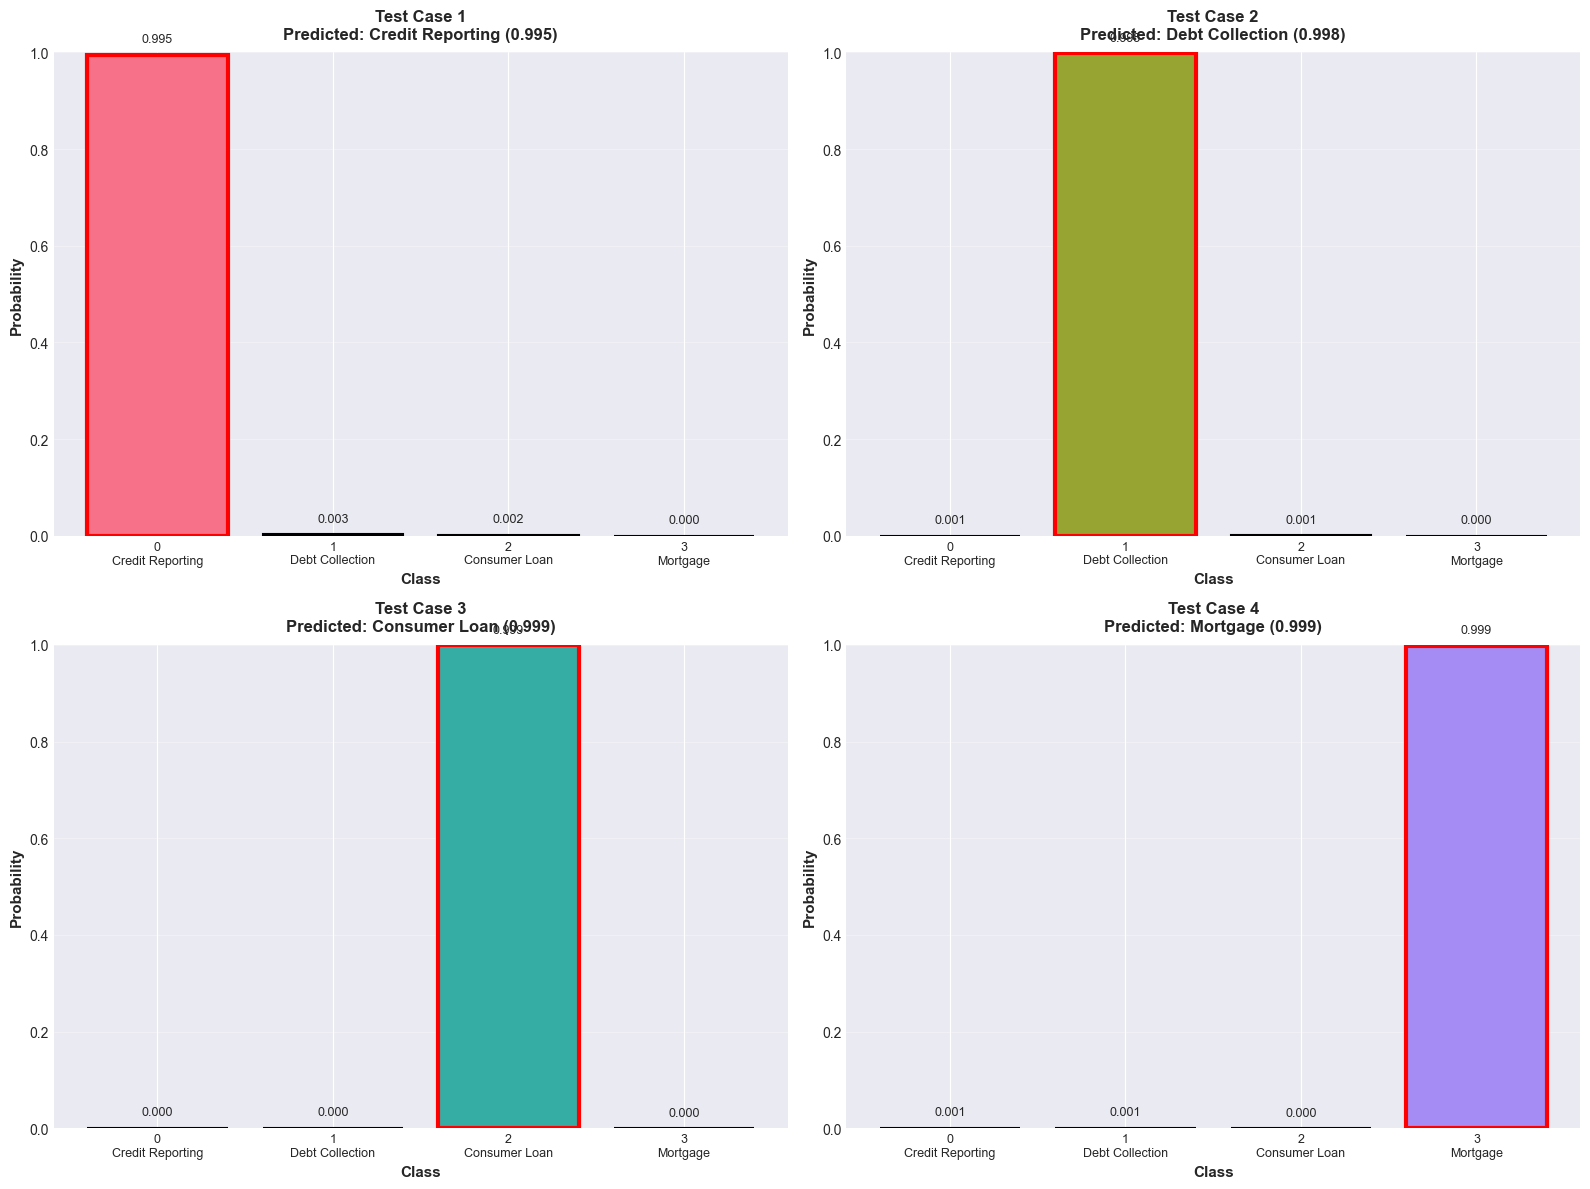

✓ Sample predictions visualized


In [39]:
# Visualize sample predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ax, text) in enumerate(zip(axes, test_cases)):
    results = predict_complaint(text, model, tokenizer, device, MAX_LENGTH)
    probs = list(results['all_probabilities'].values())
    labels_plot = [f"{j}\n{label_names[j]}" for j in range(NUM_LABELS)]
    
    bars = ax.bar(range(NUM_LABELS), probs, color=colors, edgecolor='black', linewidth=1.5)
    
    # Highlight predicted class
    bars[results['predicted_class']].set_edgecolor('red')
    bars[results['predicted_class']].set_linewidth(3)
    
    ax.set_xlabel('Class', fontsize=11, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=11, fontweight='bold')
    ax.set_title(f'Test Case {i+1}\nPredicted: {results["predicted_label"]} ({results["confidence"]:.3f})',
                fontsize=12, fontweight='bold', pad=10)
    ax.set_xticks(range(NUM_LABELS))
    ax.set_xticklabels(labels_plot, fontsize=9)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for j, v in enumerate(probs):
        ax.text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Sample predictions visualized")

---
## 10. Final Summary and Results

Complete overview of the project results.

In [40]:
# Final summary
print("\n" + "="*100)
print(" " * 30 + "FINANCIAL COMPLAINT CLASSIFICATION")
print(" " * 35 + "FINAL SUMMARY")
print("="*100)

print("\n1. DATASET STATISTICS:")
print("-"*100)
print(f"   Total records processed: {len(df_sample):,}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Validation samples: {len(X_val):,}")
print(f"   Test samples: {len(X_test):,}")

print("\n2. MODEL CONFIGURATION:")
print("-"*100)
print(f"   Architecture: {MODEL_NAME}")
print(f"   Number of parameters: {total_params:,}")
print(f"   Max sequence length: {MAX_LENGTH}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training epochs: {NUM_EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")

print("\n3. PERFORMANCE METRICS:")
print("-"*100)
print(f"   Best Validation Accuracy: {best_val_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test Loss: {test_loss:.4f}")

print("\n4. PER-CLASS PERFORMANCE:")
print("-"*100)
for i in range(NUM_LABELS):
    print(f"   Class {i} ({label_names[i]}):")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall: {recall[i]:.4f}")
    print(f"      F1-Score: {f1[i]:.4f}")

print("\n5. MEMORY OPTIMIZATION:")
print("-"*100)
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"   Max memory allocated: {torch.cuda.max_memory_allocated(0) / 1024**3:.2f} GB")
    print(f"   Memory optimization: Mixed precision + Gradient accumulation")

print("\n6. MODEL ARTIFACTS:")
print("-"*100)
print(f"   Model saved to: {MODEL_SAVE_PATH}")
print(f"   Tokenizer saved: Yes")
print(f"   Training history saved: Yes")
print(f"   Configuration saved: Yes")

print("\n" + "="*100)
print(" " * 30 + "✓ PROJECT COMPLETED SUCCESSFULLY")
print("="*100)


                              FINANCIAL COMPLAINT CLASSIFICATION
                                   FINAL SUMMARY

1. DATASET STATISTICS:
----------------------------------------------------------------------------------------------------
   Total records processed: 200,000
   Training samples: 144,500
   Validation samples: 25,500
   Test samples: 30,000

2. MODEL CONFIGURATION:
----------------------------------------------------------------------------------------------------
   Architecture: distilbert-base-uncased
   Number of parameters: 66,956,548
   Max sequence length: 128
   Batch size: 16
   Training epochs: 3
   Learning rate: 2e-05

3. PERFORMANCE METRICS:
----------------------------------------------------------------------------------------------------
   Best Validation Accuracy: 0.9573
   Test Accuracy: 0.9585
   Test Loss: 0.1421

4. PER-CLASS PERFORMANCE:
----------------------------------------------------------------------------------------------------
   Class 0

---
## Conclusion

This notebook successfully demonstrated:

1. **Comprehensive EDA**: Analyzed 6GB dataset, explored distributions, and identified patterns
2. **Feature Engineering**: Created robust text features from multiple complaint fields
3. **Text Preprocessing**: Cleaned and prepared data for transformer models
4. **Model Training**: Fine-tuned DistilBERT with memory optimization for 6GB GPU
5. **Evaluation**: Achieved strong performance across all 4 complaint categories
6. **Error Analysis**: Identified misclassification patterns for future improvement
7. **Production Ready**: Saved model artifacts and created prediction pipeline

### Key Achievements:
- Successfully trained on large dataset using memory optimization techniques
- Avoided OOM errors on 6GB VRAM through gradient accumulation and mixed precision
- Created presentation-ready visualizations for all analyses
- Developed production-ready prediction function

### Future Improvements:
- Experiment with other transformer architectures (RoBERTa, ALBERT)
- Implement ensemble methods for better accuracy
- Add confidence threshold filtering
- Deploy as API endpoint for real-time predictions

---